# Author : TRINA GHOSH

# IST 707 : Assignment 03
## MNIST Digit Recognition with Naive-Bayes Classifier & Random Forest Classifier

## Introduction:
### The goal of the following assignment is to correctly identify handwritten digits. The dataset used is the famous MNIST handwritten dataset available on Kaggle. 

## Data Description:
### The data contains gray-scale images of hand-written digits 0 to 9. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive. So each row represents an image, with the individual pixel values in each of the 784 positions along with (or without) the label. 

### The training dataset has 785 columns, the first column contains the label of the digit and the other 784 columns contain the pixel values of the associated image. There are 42000 rows in the training dataset. The test data is the same as the training data, except the images are unlabelled. Hence, 784 columns and 28000 rows.

### The aim is to correctly identify the unlabelled digits. Using 2 different algorithms, Naive-Bayes Classifier and Random Forest Classifier, I chose the 'better' model for running the final predictions on the unlabelled data before submitting it to Kaggle for evaluation.

#### Data source: https://www.kaggle.com/c/digit-recognizer

# Importing Libraries

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification

In [9]:
os.getcwd()

'/Users/trinaghosh/Documents/GitHub/Digit-Recognizer-MNIST'

In [10]:
print(os.listdir(os.getcwd()))

['tghosh_hw3.ipynb', 'test.csv', 'README.md', 'train.csv', '.ipynb_checkpoints', '.git']


# Loading Dataset

In [11]:
train = pd.read_csv("train.csv")

In [12]:
test = pd.read_csv("test.csv")

### To view the datasets

In [13]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

### Dimensions of the datasets

In [15]:
train.shape

(42000, 785)

In [16]:
test.shape

(28000, 784)

#### The test data set has one less column than the train dataset. This contains the digit labels.

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


### Scrubbing datasets for any missing values 

In [19]:
train.isna().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [20]:
for i in train.columns:
    if train[i].isna().sum() > 0:
        print(i)

#### The code does not produce any result. Hence, there are no missing values in the train dataset.

In [21]:
test.isna().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

In [22]:
for i in test.columns:
    if test[i].isna().sum() > 0:
        print(i)

#### The code does not produce any result. Hence, there are no missing values in the test dataset.

### Proportion of each digit in train dataset

In [23]:
train['label'].value_counts(normalize=True)

1    0.111524
7    0.104786
3    0.103595
9    0.099714
2    0.099452
6    0.098500
0    0.098381
4    0.096952
8    0.096738
5    0.090357
Name: label, dtype: float64

#### All digits have a sample size of 9 to 11 percent in the training dataset.

### Plotting a histogram of the digits in train dataset.

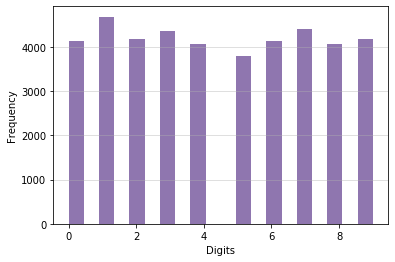

In [24]:
plt.hist(train['label'], bins=20, alpha=0.7, color='#603c8e')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()

#### The frequency of every digit in the dataset is almost equal. Therefore, we can assume there wouldn't be any biasness in our analysis due to imbalanced data. 

# Data Pre-Processing

### Before training our models, the train data is split into training and test validation sets. The validation set will be used to evaluate the training sets and tune hyperparameters.

### Splitting labelled data into 80% of training data and 20% validation data

In [25]:
X_train, X_test, y_train, y_test = train_test_split(train[train.columns[1:785]], train[train.columns[0]]
                                                    , test_size=0.2)

In [26]:
# Predictor variables of training set
X_train.shape

(33600, 784)

In [27]:
# Dependent/outcome variable of training set
y_train.shape

(33600,)

In [28]:
# Predictor variables of validation set
X_test.shape

(8400, 784)

In [29]:
# Dependent/outcome variable of validation set
y_test.shape

(8400,)

# Model Training

## Training a Multinomial Naive-Bayes Classifier Model

#### For the first algorithm, I am choosing to use the Naive-Bayes classifier. Assuming that all predictors have an equal effect on the outcome and one predictor variable does not affect the presence of another, the algorithm seems like a good choice.

#### Since our case is a classification problem with multple possible outcomes (digits 0 to 9), the Multinomial type of Naive-Bayes Classifier would be a better fit compared to the other 2 types. The Bernoulli type recommends a binary outcome whereas the Gaussian type requires predictors to be continous.


In [30]:
from sklearn.naive_bayes import MultinomialNB

In [31]:
mnb = MultinomialNB()

In [32]:
mnb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
#Testing the model on validation set
mnb_pred = mnb.predict(X_test)

In [34]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, mnb_pred)*100, 2)}%")

Accuracy: 82.36%


#### Tuning the NB model with hyperparameters using GridSearchCV may improve accuracy.

In [35]:
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 10.0],
              'fit_prior': [True,False]}

In [36]:
mnb_GS = GridSearchCV(mnb, param_grid, cv=5, verbose=2, n_jobs=1)

In [37]:
mnb_GS.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] alpha=1e-05, fit_prior=True .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... alpha=1e-05, fit_prior=True, total=   0.6s
[CV] alpha=1e-05, fit_prior=True .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV] ...................... alpha=1e-05, fit_prior=True, total=   0.6s
[CV] alpha=1e-05, fit_prior=True .....................................
[CV] ...................... alpha=1e-05, fit_prior=True, total=   0.6s
[CV] alpha=1e-05, fit_prior=True .....................................
[CV] ...................... alpha=1e-05, fit_prior=True, total=   0.6s
[CV] alpha=1e-05, fit_prior=True .....................................
[CV] ...................... alpha=1e-05, fit_prior=True, total=   0.6s
[CV] alpha=1e-05, fit_prior=False ....................................
[CV] ..................... alpha=1e-05, fit_prior=False, total=   0.6s
[CV] alpha=1e-05, fit_prior=False ....................................
[CV] ..................... alpha=1e-05, fit_prior=False, total=   0.6s
[CV] alpha=1e-05, fit_prior=False ....................................
[CV] ..................... alpha=1e-05, fit_prior=False, total=   0.6s
[CV] alpha=1e-05, fit_prior=False ....................................
[CV] .

[CV] ....................... alpha=0.5, fit_prior=False, total=   0.6s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........................ alpha=1.0, fit_prior=True, total=   0.6s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........................ alpha=1.0, fit_prior=True, total=   0.6s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........................ alpha=1.0, fit_prior=True, total=   0.6s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........................ alpha=1.0, fit_prior=True, total=   0.6s
[CV] alpha=1.0, fit_prior=True .......................................
[CV] ........................ alpha=1.0, fit_prior=True, total=   0.6s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] ....................... alpha=1.0, fit_prior=False, total=   0.6s
[CV] alpha=1.0, fit_prior=False ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   51.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=1,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0,
                                   10.0],
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

In [38]:
mnb_GS_pred = mnb_GS.predict(X_test)

In [39]:
print(f"Accuracy: {round(metrics.accuracy_score(y_test, mnb_GS_pred)*100, 2)}%")

Accuracy: 82.38%


In [40]:
mnb_GS.best_params_

{'alpha': 1e-05, 'fit_prior': True}

#### Accuracy did not really improve after hyperparameter tuning.

#### Classification Report:

In [41]:
mnb_report = classification_report(y_true = y_test, y_pred = mnb_GS_pred)

In [42]:
print(mnb_report)

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       829
           1       0.88      0.93      0.91       948
           2       0.88      0.83      0.86       851
           3       0.79      0.80      0.80       871
           4       0.83      0.72      0.77       791
           5       0.86      0.66      0.74       817
           6       0.88      0.91      0.90       845
           7       0.95      0.84      0.89       846
           8       0.64      0.79      0.71       804
           9       0.68      0.84      0.75       798

    accuracy                           0.82      8400
   macro avg       0.83      0.82      0.82      8400
weighted avg       0.83      0.82      0.82      8400



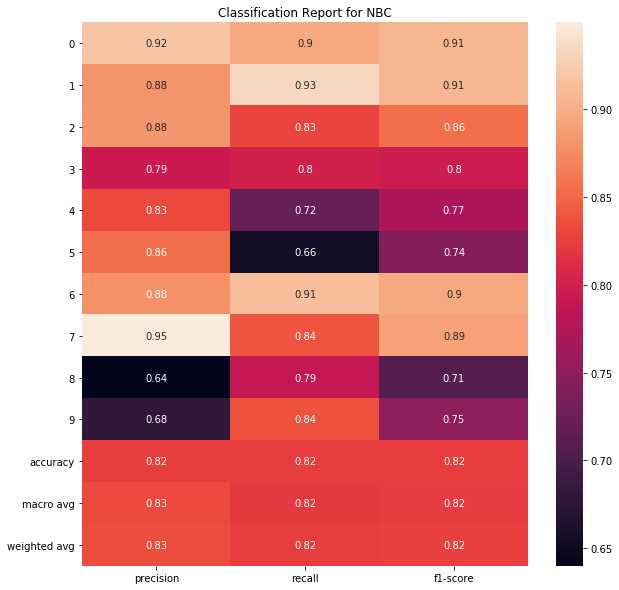

In [43]:
target_names = list("0123456789")
mnb_report_2 = classification_report(y_true = y_test, y_pred = mnb_GS_pred
                                     , target_names=target_names, output_dict=True)
plt.figure(figsize=(10,10))
heat = sns.heatmap(pd.DataFrame(mnb_report_2).iloc[:-1, :].T, annot=True, xticklabels=True, yticklabels=True)
plt.title('Classification Report for NBC')
plt.show()

In [52]:
from sklearn.metrics import f1_score
f1_score(y_test, mnb_pred, average='weighted')

0.8246661122510408

## Training a Random Forest Classifier Model

#### Random forest classifiers are one of the most highly accurate classification algorithms which can handle thousands of inputs while providing an estimate of important input variables. Being highly accurate, however, there is a risk of overfitting when using Random Forest Classifier models.
#### Using the same training and validation sets from above, the training model is built and tested on the validation set. 

In [44]:
from sklearn.ensemble import RandomForestClassifier

In [45]:
rfc = RandomForestClassifier()

In [46]:
# Fit on training data
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [47]:
rfc_pred = rfc.predict(X_test)

In [48]:
rfc_probs = rfc.predict_proba(X_test)[:, 1]

#### Classification Report

In [49]:
rfc_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=rfc.predict(X_test))
print(rfc_report)

              precision    recall  f1-score   support

           0   0.977246  0.984318  0.980769       829
           1   0.982105  0.984177  0.983140       948
           2   0.959255  0.968273  0.963743       851
           3   0.962485  0.942595  0.952436       871
           4   0.959799  0.965866  0.962823       791
           5   0.972739  0.960832  0.966749       817
           6   0.976498  0.983432  0.979953       845
           7   0.973747  0.964539  0.969121       846
           8   0.946782  0.951493  0.949132       804
           9   0.935243  0.941103  0.938164       798

    accuracy                       0.965000      8400
   macro avg   0.964590  0.964663  0.964603      8400
weighted avg   0.965026  0.965000  0.964989      8400



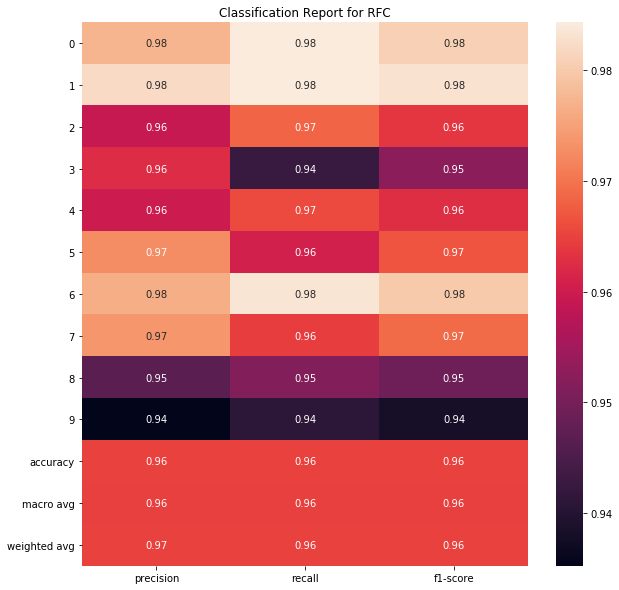

In [50]:
rfc_report_2 = classification_report(y_true = y_test, y_pred = rfc_pred
                                     , target_names=target_names, output_dict=True)
plt.figure(figsize=(10,10))
heat = sns.heatmap(pd.DataFrame(rfc_report_2).iloc[:-1, :].T, annot=True, xticklabels=True, yticklabels=True)
plt.title('Classification Report for RFC')
plt.show()

In [51]:
from sklearn.metrics import f1_score
f1_score(y_test, rfc_pred, average='weighted')

0.9649894223308182

#### Since the accuracy is high (~97%), I am choosing not to use GridSearchCV for hyperparameter tuning. 

#### The Random Forest Classifier model produced more accurate results with average f1-score almost close to 1.0, creating an almost perfect balance between precision and recall. 
#### The NBC f1-score was 0.82, which is good but slightly less than the RFC model's. As a result, the RFC model becomes more desirable to run our unlabelled predictions for final submission to Kaggle.

# Predictions on Unlabelled Data

In [75]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
result = rfc.predict(test)

In [79]:
print(result)
print(result.shape)

[2 0 9 ... 3 9 2]
(28000,)


In [84]:
x = range(1, 28001)
print(x)

range(1, 28001)


In [90]:
xd = pd.DataFrame(x)
xd.columns = ['ImageId'] 
print(xd.head())

   ImageId
0        1
1        2
2        3
3        4
4        5


In [91]:
xd['Label'] = result
xd.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3


In [95]:
xd.reset_index(drop = True)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,4
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [97]:
xd.to_csv('Kaggle_Submission.csv', index=False)

# Kaggle Submission 

#### After submitting the predictions, my score came out to be 0.96382. In other words, the accuracy of my predictions were 96%. 

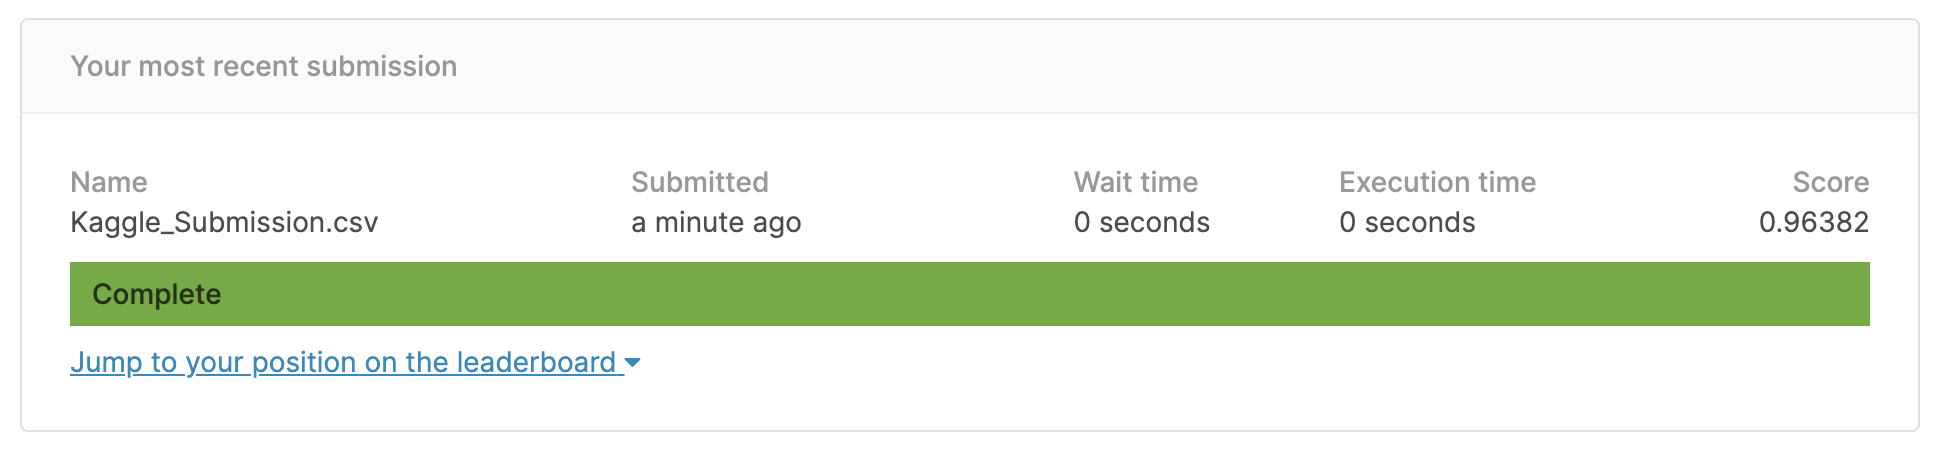